# 🏦 GESTÃO DE RISCO: MODELO DE SCORING BASILEIA (PD)
**Mesa de Operações:** Risco de Crédito Comercial
**Objetivo:** Calcular a Probabilidade de Default (PD) para o cálculo da Perda Esperada ($EL = PD \times LGD \times EAD$).

## 1. Setup e Governança de Infraestrutura
Este bloco inicializa o radar de navegação e a blindagem do código.
* **Hot Reload (`%autoreload`):** Mitiga o Risco Operacional de memória em cache. Permite que o Jupyter leia atualizações na biblioteca central (`src/`) em tempo real, sem necessidade de reiniciar o servidor (Zero Downtime).
* **Isolamento de Domínio (`src/`):** A matemática pesada e as regras de negócio foram encapsuladas fora do Notebook para garantir rastreabilidade e evitar execução de células fora de ordem.

In [3]:
# 1. Ativa o radar de atualização em tempo real (Hot Reload)
%load_ext autoreload
%autoreload 2

# Visor, GPS e Conexão 
import sys, pandas as pd
from pathlib import Path
import numpy as np
from sklearn.linear_model import LogisticRegression



# Configura o visor financeiro
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

# GPS Dinâmico e Blindado: Acha a raiz do projeto automaticamente
raiz = Path.cwd() if Path.cwd().joinpath('src').exists() else Path.cwd().parent
sys.path.append(str(raiz))

# Conecta os motores
from src.data_ingestion import carregar_base_basileia, remover_colunas_toxicas
from src.feature_engineering import (
    calcular_historico_credito, 
    padronizar_tempo_emprego, 
    criar_variaveis_dummy, 
    imputar_dados_nulos, 
    remover_colunas_toxicas, 
    definir_variavel_alvo, 
    dividir_treino_teste
)
# 2Gaveta da Matemática
from src.woe_iv import calcular_woe_iv, injetar_woe_na_base

#  Gaveta de Escalonamento
from src.scorecard_scaler import calcular_score_final, aplicar_politica_decisao_original, aplicar_politica_decisao_quartis 


# AS TOMADAS DE ENERGIA DESTA CÉLULA (O REAGENTE DO LABORATÓRIO)
from sklearn.metrics import roc_auc_score
#  Gaveta de Gráficos (Somente visualização)
from src.plots_woe import auditar_tendencia_woe, auditar_curva_roc

print(f"STATUS: Cockpit alinhado. Rota travada em: {raiz}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
STATUS: Cockpit alinhado. Rota travada em: C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling


## 2. Esteira ETL e Engenharia de Variáveis (Feature Engineering)
Este é o motor principal de tratamento de dados. Ele extrai a base bruta e a transforma em uma matriz matemática de risco.

**Fundamentos Matemáticos e de Negócio:**
1. **Remoção de Ativos Tóxicos:** Variáveis com mais de 50% de dados nulos (NaN) são sumariamente ejetadas (Drop). Tentar imputar dados com esse nível de ausência configuraria fraude estatística (distorção severa da variância).
2. **Prevenção de Data Leakage (Vazamento de Dados):** A variável original `loan_status` é excluída da base. Se mantida, o algoritmo usaria o futuro (o calote já consumado) para prever o passado, gerando uma correlação espúria perfeita ($R^2 = 1$).
3. **A Bússola de Risco (Target):** Criação da variável binária `good_bad_loan` operando em baixo nível via `np.where`.
   * **1 (Lucro):** Clientes adimplentes (Current, Fully Paid).
   * **0 (Loss / PD):** Clientes em default (Charged Off, Late > 31 dias). Representam o alvo da nossa modelagem.

In [4]:
# A Execução do ETL
print("STATUS: Iniciando esteira de processamento completa...")

# 1. Extração
loan_data = carregar_base_basileia()

# 2. Descarte de Ativos Tóxicos (Cortamos tudo com mais de 50% de buracos)
loan_data = remover_colunas_toxicas(loan_data, limite_toxicidade=0.50)

# 3. Tratamento Temporal
loan_data['emp_length_int'] = padronizar_tempo_emprego(loan_data)
loan_data['mths_since_earliest_cr_line'] = calcular_historico_credito(loan_data, 'earliest_cr_line')

# 4. Tratamento de Nulos (O nosso motor de Imputação)
loan_data = imputar_dados_nulos(loan_data)

# 5. Criação do Gabarito (Target) e Isolamento de Vazamento de Dados
loan_data = definir_variavel_alvo(loan_data)

# 6. Limpeza de RAM (Descarte de colunas processadas e sujas)
# Proteção contra estrangulamento de memória do servidor
loan_data = loan_data.drop(columns=['earliest_cr_line', 'emp_length', 'loan_status'])

print(f"STATUS: SUCESSO. Base limpa e lacrada. Formato atual: {loan_data.shape}")

STATUS: Iniciando esteira de processamento completa...
STATUS: Rota confirmada. Iniciando leitura de loan_data_2007_2014.csv...
SUCESSO: 466285 linhas extraídas para a RAM.
STATUS: SUCESSO. Base limpa e lacrada. Formato atual: (466285, 54)


## 3. Auditoria de Dívida Técnica (Missing Data)
Antes da injeção na Regressão Logística, a matriz $(X^T X)^{-1}$ não pode conter valores nulos (`NaN`), sob pena de matriz singular e colapso do motor.

**Protocolo de Imputação vs. Drop:**
* Este radar varre a base em busca de furos na fuselagem.
* Variáveis com nulos marginais (< 5%) serão tratadas no nosso "Hospital de Dados" (`src/`) usando Proxies Financeiras ou preenchimento conservador (ex: assumir zero para valores em cobrança não reportados), preservando a integridade do Capital do banco.

In [5]:
# Auditoria Financeira de Dados Nulos (NaN)

print("STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...")

# 1. A Matemática do Rombo
total_linhas = len(loan_data)
nulos_abs = loan_data.isnull().sum()
nulos_perc = (nulos_abs / total_linhas) * 100

# 2. A Construção do Balanço Patrimonial (DataFrame limpo)
relatorio_nulos = pd.DataFrame({
    'Total_Vazios': nulos_abs,
    'Percentual (%)': nulos_perc
})

# 3. O Filtro de Toxicidade: Queremos ver apenas quem tem rombo, do pior (maior %) para o melhor
relatorio_nulos = relatorio_nulos[relatorio_nulos['Total_Vazios'] > 0].sort_values(by='Percentual (%)', ascending=False)

print(f"ALERTA: O radar detectou {len(relatorio_nulos)} variáveis com dados faltantes na fuselagem.\n")
display(relatorio_nulos.head(15)) # Imprime as 15 variáveis mais tóxicas

STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...
ALERTA: O radar detectou 18 variáveis com dados faltantes na fuselagem.



,Total_Vazios,Percentual (%)
next_pymnt_d,227214,48.7286
tot_cur_bal,70276,15.0715
tot_coll_amt,70276,15.0715
emp_title,27588,5.9166
emp_length_int,21008,4.5054
last_pymnt_d,376,0.0806
revol_util,340,0.0729
collections_12_mths_ex_med,145,0.0311
last_credit_pull_d,42,0.0090
pub_rec,29,0.0062


In [6]:
# 1. Execução do fatiamento (O motor fará a separação e devolverá as 4 caixas)
X_train, X_test, y_train, y_test = dividir_treino_teste(loan_data)

# 2. A Fusão para o Motor de WoE
df_treino_woe = pd.concat([X_train, y_train], axis=1)

# 3. Auditoria visual do chassi
print("STATUS: Fatiamento e colagem concluídos.")
print("Tamanho do Treino (X):", X_train.shape)
print("Tamanho do Teste (X):", X_test.shape)
print(f"Tamanho do df_treino_woe forjado na memória: {df_treino_woe.shape}")

STATUS: Fatiamento e colagem concluídos.
Tamanho do Treino (X): (373028, 53)
Tamanho do Teste (X): (93257, 53)
Tamanho do df_treino_woe forjado na memória: (373028, 54)



 STATUS: Gerando Laudo de Risco >>> GRADE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


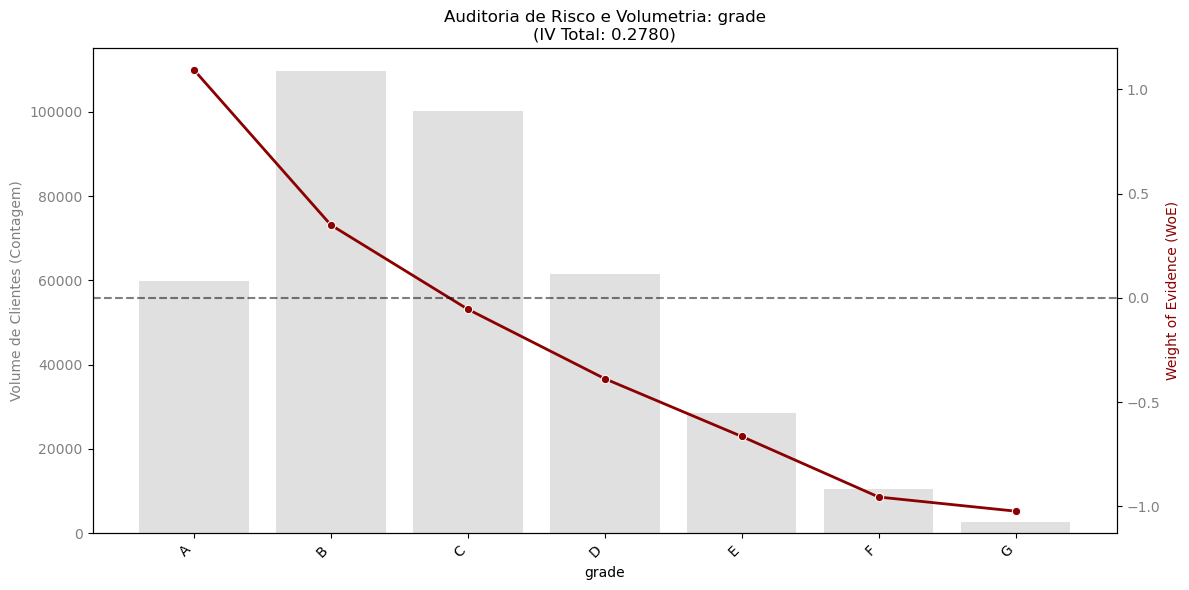


 STATUS: Gerando Laudo de Risco >>> EMP_LENGTH_INT <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


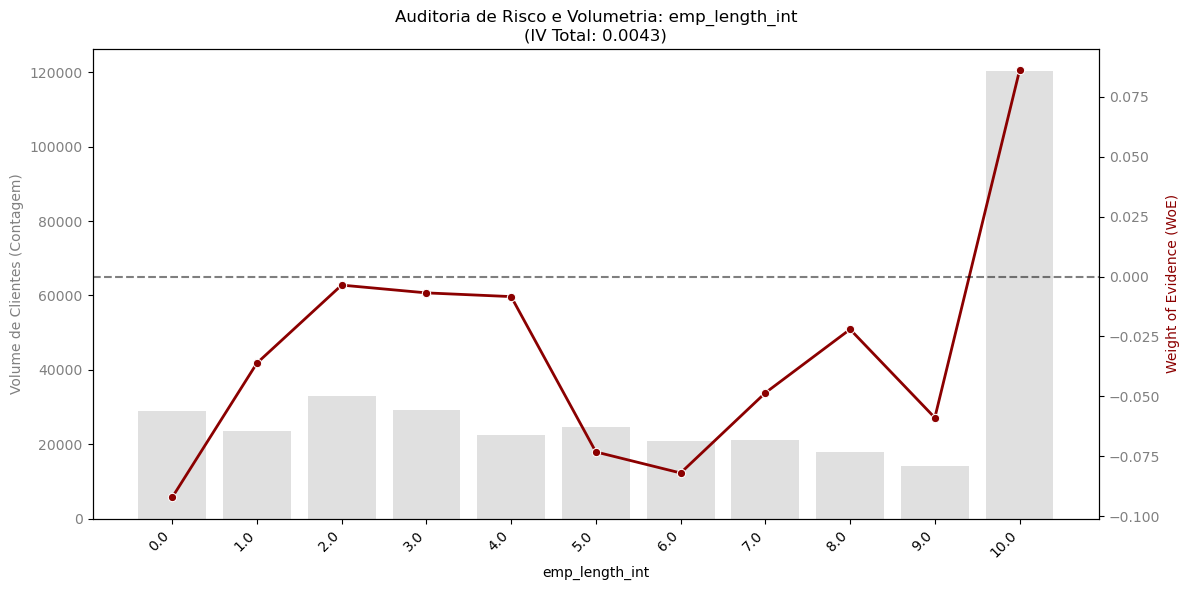


 STATUS: Gerando Laudo de Risco >>> HOME_OWNERSHIP <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


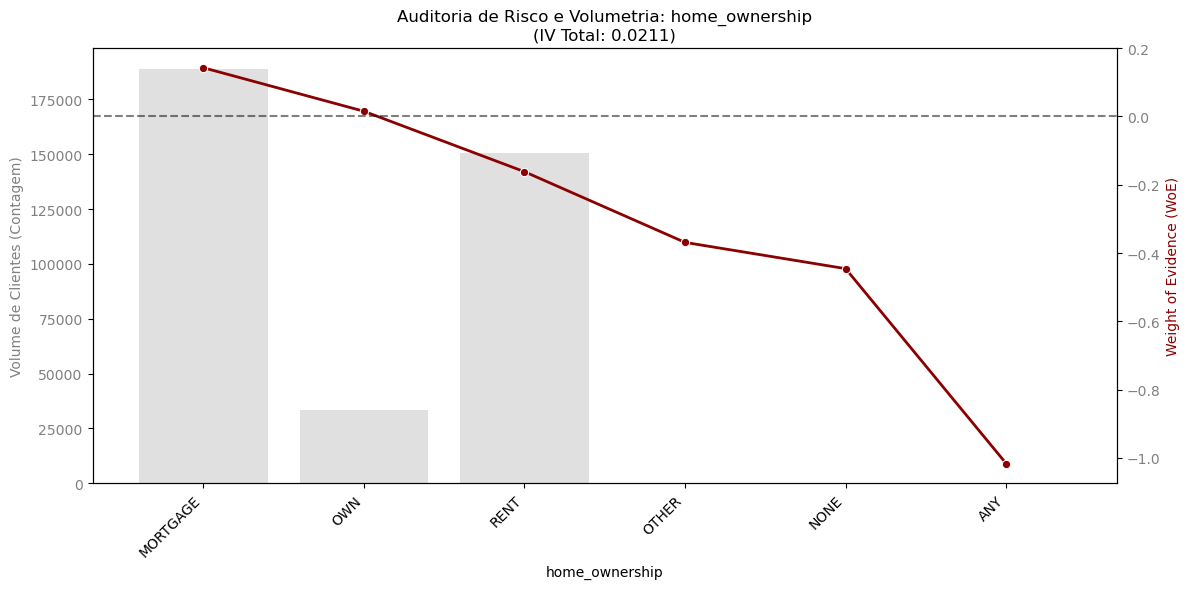


 STATUS: Gerando Laudo de Risco >>> VERIFICATION_STATUS <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


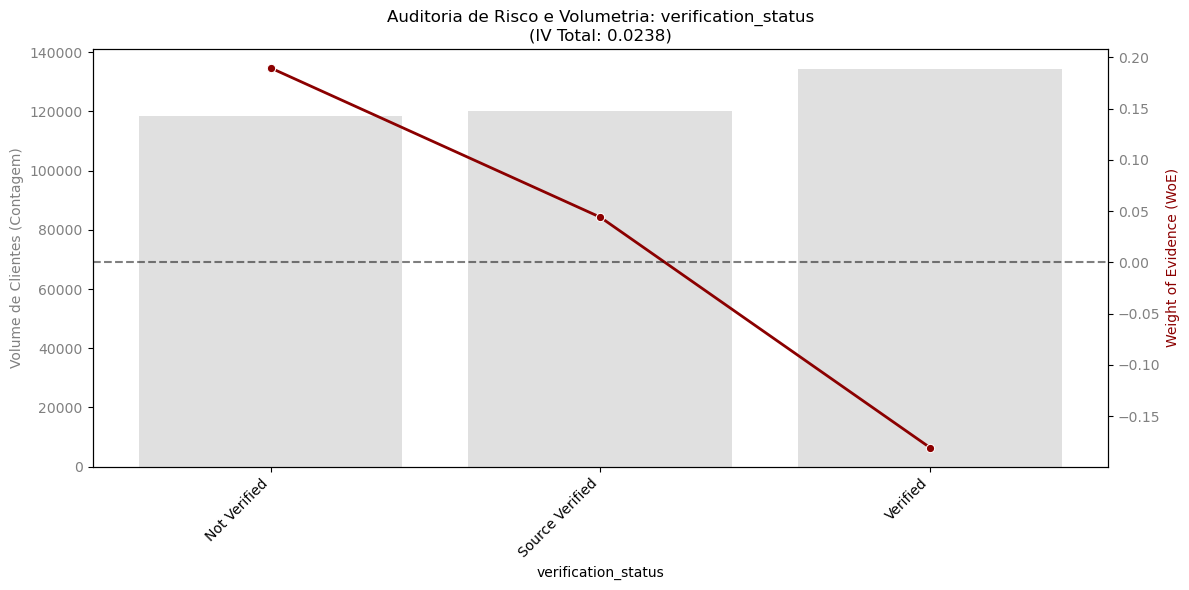


 STATUS: Gerando Laudo de Risco >>> PURPOSE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


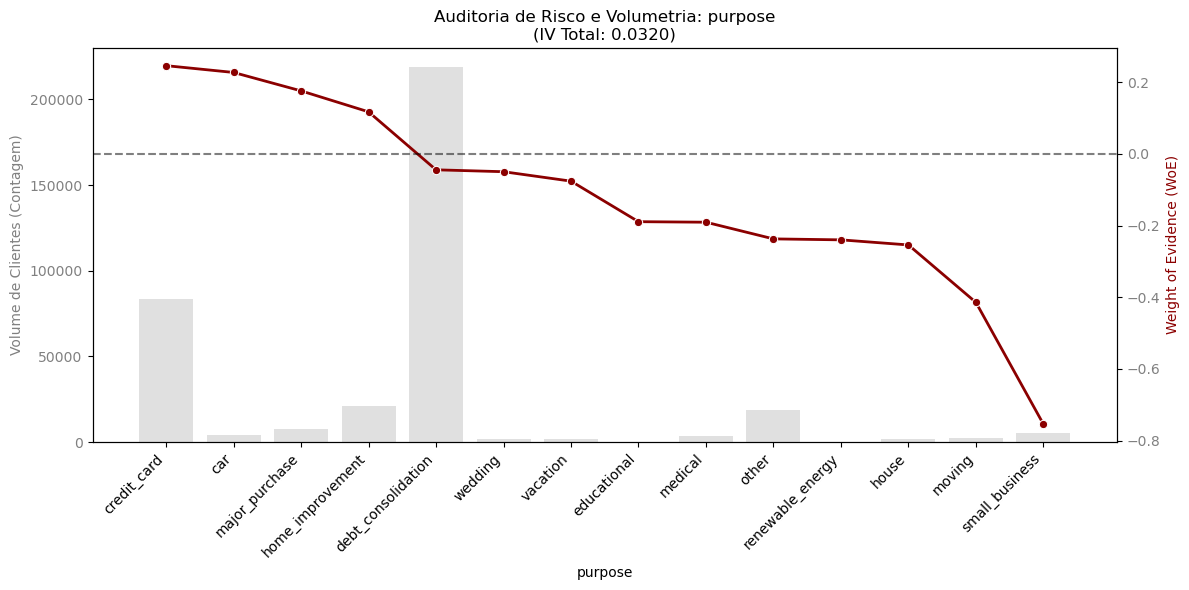


 STATUS: Gerando Laudo de Risco >>> INITIAL_LIST_STATUS <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


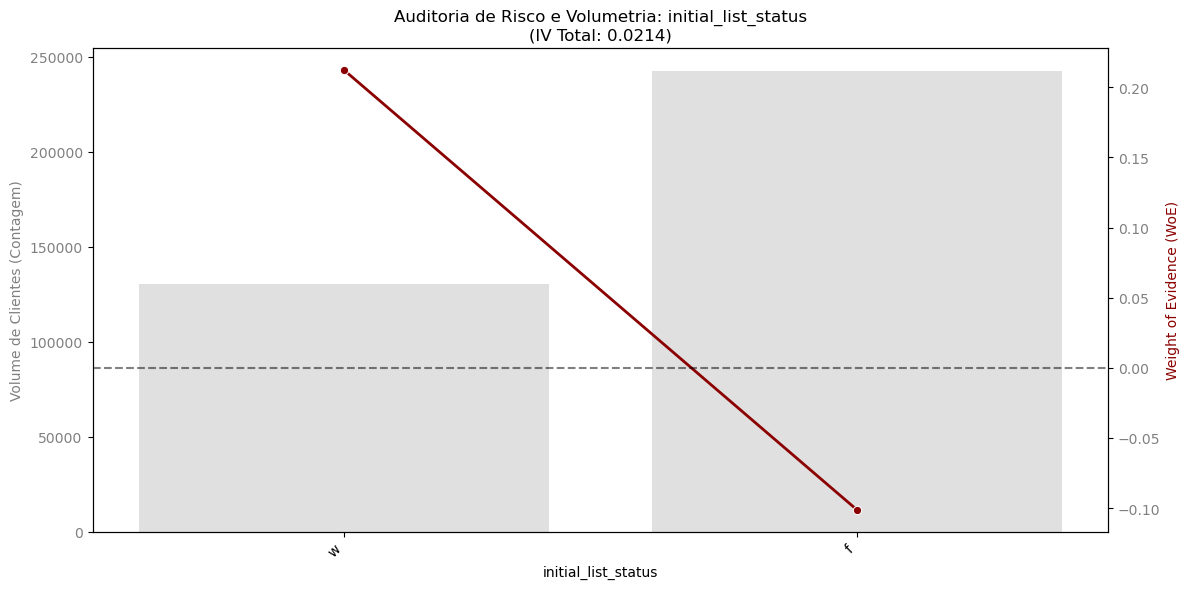


 STATUS: Gerando Laudo de Risco >>> TERM <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


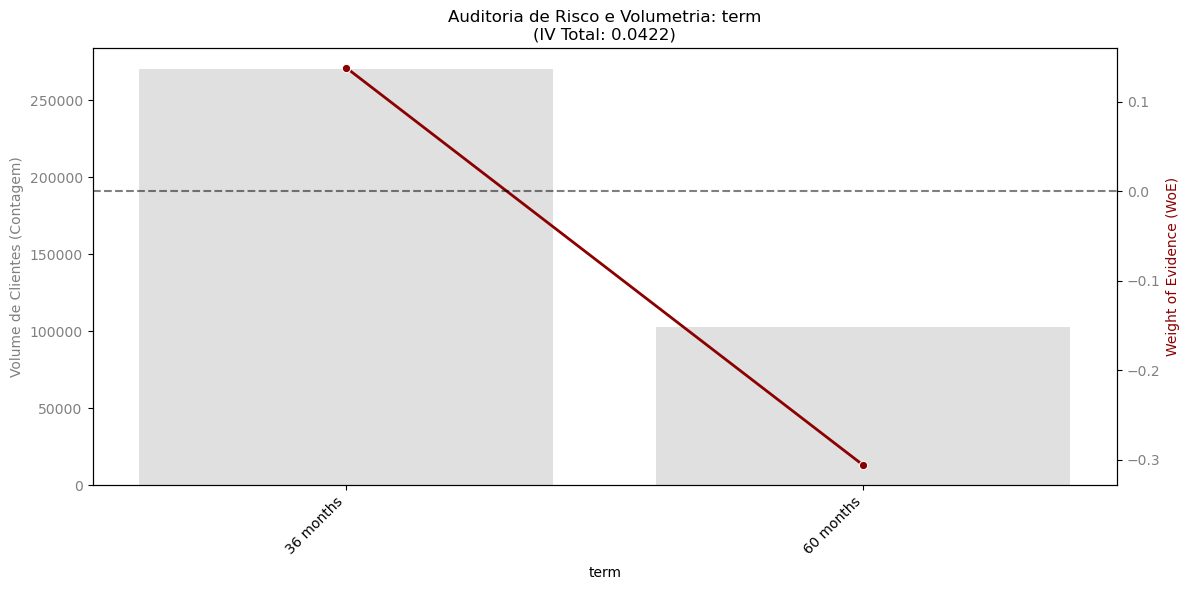

In [7]:
# -------------------------------------------------------------------
# MOTOR DE AUDITORIA: SCANNER 360º DE VARIÁVEIS 
# -------------------------------------------------------------------

# 1. A Lista de Interrogatório Completa (O pente-fino do Risco)
colunas_para_testar = [
    'grade',                # A nossa variável Padrão Ouro
    'emp_length_int',       # O lixo estatístico (mantido para a Trilha de Auditoria)
    'home_ownership',       # Tipo de moradia
    'verification_status',  # Renda verificada
    'purpose',              # Motivo do empréstimo
    'initial_list_status',  # Status inicial na esteira
    'term'                  # Prazo do empréstimo (se existir)
]

coluna_alvo = 'good_bad_loan' 

# 2. O Loop do Auditor: Varredura total
for coluna in colunas_para_testar:
    # Trava de segurança: Só roda se a coluna existir na base
    if coluna in df_treino_woe.columns:
        print(f"\n{'='*70}")
        print(f" STATUS: Gerando Laudo de Risco >>> {coluna.upper()} <<<")
        print(f"{'='*70}")
        
        # O motor calcula o peso matemático da variável da vez
        df_tabela_woe = calcular_woe_iv(df_treino_woe, coluna, coluna_alvo)
        
        # O painel exibe o raio-x (Gráfico)
        auditar_tendencia_woe(df_tabela_woe, coluna)
    else:
        print(f"ALERTA: A variável '{coluna}' não foi encontrada na fuselagem do X_train.")



In [8]:
# Lista de variáveis que passaram no crivo do IV e da Monotonicidade
variaveis_aprovadas = ['grade', 'home_ownership', 'purpose', 'verification_status']

print("STATUS: Iniciando injeção de pesos de risco (WoE)...")

for col in variaveis_aprovadas:
    # Geramos a tabela de referência de WoE (usando apenas o treino para evitar Leakage)
    df_ref_woe = calcular_woe_iv(df_treino_woe, col, 'good_bad_loan')
    
    # Injetamos os valores no X_train e no X_test
    X_train = injetar_woe_na_base(X_train, df_ref_woe, col)
    X_test = injetar_woe_na_base(X_test, df_ref_woe, col)

print("STATUS: Sucesso. Base transformada em puro risco matemático.")
display(X_train[[f"{c}_woe" for c in variaveis_aprovadas]].head())

STATUS: Iniciando injeção de pesos de risco (WoE)...
STATUS: Sucesso. Base transformada em puro risco matemático.


,grade_woe,home_ownership_woe,purpose_woe,verification_status_woe
427211,1.0938,0.1427,-0.0445,0.0440
206088,-0.0548,0.1427,-0.0445,0.1896
136020,1.0938,0.1427,-0.0445,-0.1807
412305,-0.3881,-0.1617,-0.0445,0.0440
36159,-0.0548,0.1427,-0.1892,-0.1807


In [9]:
# -------------------------------------------------------------------
# ETAPA 8: O CÉREBRO DO SCORECARD (REGRESSÃO LOGÍSTICA)
# -------------------------------------------------------------------

# 1. Separamos as nossas ferramentas cirúrgicas (Apenas as colunas WoE)
colunas_woe = [f"{c}_woe" for c in variaveis_aprovadas]

# O algoritmo só vai enxergar a matemática pura
X_train_modelo = X_train[colunas_woe]
X_test_modelo = X_test[colunas_woe]

print("STATUS: Iniciando o treinamento do algoritmo preditivo...")

# 2. Instanciamos o robô (Configuração padrão de Risco)
modelo_scorecard = LogisticRegression(max_iter=1000, random_state=42)

# 3. O Treinamento (Onde o robô aprende quem paga e quem dá calote)
modelo_scorecard.fit(X_train_modelo, y_train)

print("STATUS: Sucesso. O modelo foi treinado com os dados da carteira.")

# 4. Auditoria de Pesos do Robô (Qual variável ele achou mais importante?)
pesos_do_modelo = pd.DataFrame({
    'Variável': colunas_woe, 
    'Importância_no_Modelo': modelo_scorecard.coef_[0]
})

# Mostramos o que o robô priorizou
display(pesos_do_modelo.sort_values(by='Importância_no_Modelo', ascending=False))

STATUS: Iniciando o treinamento do algoritmo preditivo...
STATUS: Sucesso. O modelo foi treinado com os dados da carteira.


,Variável,Importância_no_Modelo
0,grade_woe,0.9301
1,home_ownership_woe,0.8222
2,purpose_woe,0.4470
3,verification_status_woe,0.4303


STATUS: Treinando o algoritmo preditivo...
 STATUS: Auditoria Preditiva Concluída.
 Métrica AUC:  0.6550
 Métrica GINI: 0.3100 (31.00%)


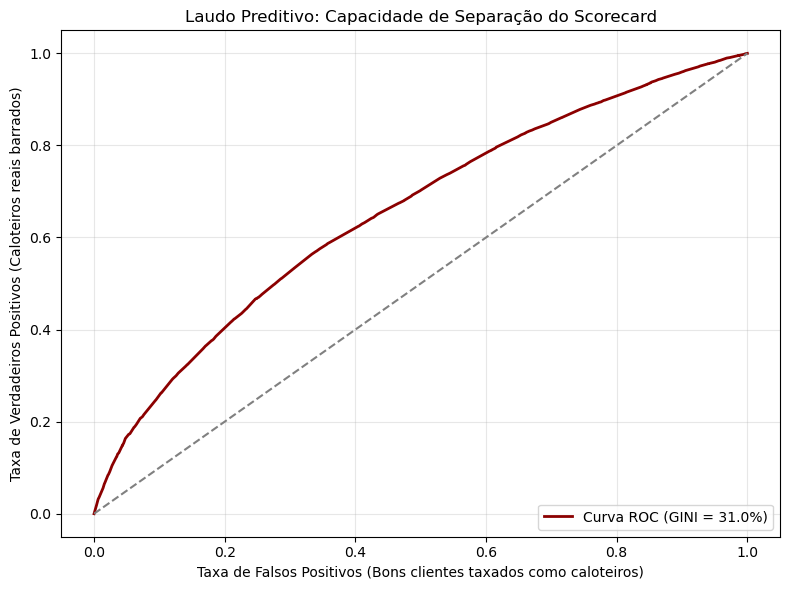

In [10]:
# ===================================================================
# ETAPA 7: O CÉREBRO DO SCORECARD E VALIDAÇÃO ESTATÍSTICA
# ===================================================================
colunas_woe = [f"{c}_woe" for c in variaveis_aprovadas]
X_train_modelo = X_train[colunas_woe]
X_test_modelo = X_test[colunas_woe]

print("STATUS: Treinando o algoritmo preditivo...")

# 1. Instanciamos e Treinamos o robô
modelo_scorecard = LogisticRegression(max_iter=1000, random_state=42)
modelo_scorecard.fit(X_train_modelo, y_train)

# 2. Extração de Probabilidades na base de Teste
probabilidades_calote = modelo_scorecard.predict_proba(X_test_modelo)[:, 1]

# 3. Cálculo de GINI e AUC
auc = roc_auc_score(y_test, probabilidades_calote)
gini = (auc * 2) - 1

print(f"{'='*50}")
print(f" STATUS: Auditoria Preditiva Concluída.")
print(f" Métrica AUC:  {auc:.4f}")
print(f" Métrica GINI: {gini:.4f} ({gini*100:.2f}%)")
print(f"{'='*50}")

# 4. O Laudo Visual
auditar_curva_roc(y_test, probabilidades_calote, gini)

In [11]:
# 1. Aplicamos a escala nas probabilidades que o robô gerou
X_test['Score_Final'] = calcular_score_final(probabilidades_calote)

# 2. Auditoria de Faixas de Risco
print("STATUS: Scores gerados com sucesso.")
display(X_test[['Score_Final']].describe())

# 3. Amostragem para o Diretor Comercial
# Vamos ver os 5 primeiros clientes e sua 'nota' de crédito
display(X_test[['grade', 'Score_Final']].head())

STATUS: Scores gerados com sucesso.


,Score_Final
count,93257.0000
mean,535.0567
std,16.5835
min,500.0000
25%,526.0000
50%,536.0000
75%,547.0000
max,582.0000


,grade,Score_Final
362514,C,537
288564,E,552
213591,C,539
263083,C,537
165001,A,509


In [14]:
# 1. Aplicando a política na base de teste
X_test = aplicar_politica_decisao_original(X_test)

# 2. Cruzar a decisão com o calote real para validação
X_test['Calote_Real'] = y_test

# 3. O Laudo do Auditor: Tabela de Contingência
tabela_decisao = pd.crosstab(X_test['Rating'], X_test['Decisao'])
print('STATUS: Matriz de Decisão gerada.')
display(tabela_decisao)

# 4. Cálculo do Loss Evitado (Simulação Financeira)
# REGRA DE OURO: Parênteses isolando cada condição lógica
filtro = (X_test['Decisao'] == 'REPROVADO') & (X_test['Calote_Real'] == 1)

clientes_barrados = X_test[filtro].shape[0]
loss_evitado = clientes_barrados * 10000 # Custo médio de 10k por calote

print(f"\nAUDITORIA FINAL: O modelo barrou {clientes_barrados} prejuízos reais.")
print(f"ESTIMATIVA DE LUCRO: R$ {loss_evitado:,.2f} em 'Loss' evitado para o banco.")

STATUS: Matriz de Decisão gerada.


Decisao,APROVADO
Rating,
C (Risco Médio),93257



AUDITORIA FINAL: O modelo barrou 0 prejuízos reais.
ESTIMATIVA DE LUCRO: R$ 0.00 em 'Loss' evitado para o banco.


In [15]:
print("STATUS: Gerando Scores e analisando a distribuição...")

# 1. Transformação em Score
X_test['Score_Final'] = calcular_score_final(probabilidades_calote)

# 2. O Raio-X ÚNICO (Sem redundância)
display(X_test['Score_Final'].describe())

print("\nSTATUS: Calculando o impacto financeiro da Política de Crédito...")

# 3. A Bifurcação (Preservando a Matemática)
df_comite_risco = X_test[['grade_woe', 'home_ownership_woe', 'Score_Final']].copy()
df_comite_risco['Calote_Real'] = y_test

# 4. Aplicação da Régua de Risco (Quartis)
df_comite_risco = aplicar_politica_decisao_quartis(df_comite_risco)

# 5. A Tabela de Contingência
tabela_decisao = pd.crosstab(df_comite_risco['Rating'], df_comite_risco['Decisao'])
print('\nSTATUS: Matriz de Decisão Estratégica (V1) gerada.')
display(tabela_decisao)

# 6. O Cálculo do Lucro (Business Case)
filtro_loss = (df_comite_risco['Decisao'] == 'REPROVADO') & (df_comite_risco['Calote_Real'] == 1)
clientes_barrados = df_comite_risco[filtro_loss].shape[0]
loss_evitado = clientes_barrados * 10000 

print(f"\n{'='*65}")
print(f" AUDITORIA FINAL DO V1: O modelo barrou {clientes_barrados} caloteiros reais.")
print(f" ESTIMATIVA DE LUCRO: R$ {loss_evitado:,.2f} em 'Loss' evitado para o banco.")
print(f"{'='*65}")

STATUS: Gerando Scores e analisando a distribuição...


count   93257.0000
mean      535.0567
std        16.5835
min       500.0000
25%       526.0000
50%       536.0000
75%       547.0000
max       582.0000
Name: Score_Final, dtype: float64


STATUS: Calculando o impacto financeiro da Política de Crédito...

STATUS: Matriz de Decisão Estratégica (V1) gerada.


Decisao,APROVADO,REPROVADO
Rating,,
A (Risco Mínimo),23902,0
B (Risco Baixo),25103,0
C (Risco Médio),21116,0
D (Risco Alto),0,8909
E (Risco Crítico),0,14227



 AUDITORIA FINAL DO V1: O modelo barrou 22083 caloteiros reais.
 ESTIMATIVA DE LUCRO: R$ 220,830,000.00 em 'Loss' evitado para o banco.
